# An implementation of Adaptive Bayesian Neural Networks (ABNN) for a basic CNN image classifier on CIFAR-10 dataset

## Import libraries and datasets

In [ ]:
import random
random.seed(42)

In [1]:
!pip install netcal
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from torchsummary import summary
from torch.nn.functional import softmax
import torch.nn.functional as F
import netcal.metrics as metrics
from netcal.metrics import ECE
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve

# Import ABNN's essential components
# from ABNN import BNL, CustomMAPLoss, replace_normalization_layers
# from ABNN_Metrics import (
#         calculate_accuracy, calculate_uncertainty, calculate_nll, calculate_ece,
#         calculate_aupr, calculate_auc, calculate_fpr95, count_parameters,
#         predict_with_uncertainty, plot_uncertainty
#     )

# Import the base CNN model
# from Simple_CNN import Net

# Set the start method to 'spawn'
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

### Load and Augment CIFAR-10

Similar to the paper, I only use Horizontal Flip for data augmentation

In [3]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


##  Train the base model and save the weights

### Define the base CNN model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Using BatchNorm here for conv layer
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.in2 = nn.InstanceNorm2d(64, affine=True)  # Using InstanceNorm here for conv layer
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.ln3 = nn.LayerNorm([128, 8, 8])  # Using LayerNorm here for conv layer

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.ln4 = nn.LayerNorm(256)  # Using LayerNorm here for fc layer
        self.fc2 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)  # Using BatchNorm here for fc layer
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.in2(self.conv2(x))))
        x = self.pool(F.relu(self.ln3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.ln4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        return x

In [6]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net()
net.to(device)  # Move the model to GPU if available

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln3): LayerNorm((128, 8, 8), eps=1e-05, elementwise_affine=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (ln4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
# Print the summary of the model
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
    InstanceNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
         LayerNorm-8            [-1, 128, 8, 8]          16,384
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 256]         524,544
        LayerNorm-11                  [-1, 256]             512
           Linear-12                  [-1, 128]          32,896
      BatchNorm1d-13                  [-1, 128]             256
           Linear-14                   

### Train the base CNN model

For the training of our base model, I use standard image classification methods: standard cross-entropy loss and SGD

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [9]:
# Timing the training process
start_time = time.time()

# Training
train_losses = []

# Training
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(loss.item())

    print(f'[epoch {epoch + 1}, loss: {running_loss / 3000:.6f}')
    running_loss = 0

end_time = time.time()

print('Finished Training')
print(f'Time taken to train the model: {end_time - start_time:.2f} seconds')

[epoch 1, loss: 0.154708
[epoch 2, loss: 0.107863
[epoch 3, loss: 0.092632
[epoch 4, loss: 0.082888
[epoch 5, loss: 0.075239
[epoch 6, loss: 0.069646
[epoch 7, loss: 0.064024
[epoch 8, loss: 0.060947
[epoch 9, loss: 0.056376
[epoch 10, loss: 0.053229
[epoch 11, loss: 0.049484
[epoch 12, loss: 0.046479
[epoch 13, loss: 0.043952
[epoch 14, loss: 0.041753
[epoch 15, loss: 0.038616
[epoch 16, loss: 0.037123
[epoch 17, loss: 0.035332
[epoch 18, loss: 0.033494
[epoch 19, loss: 0.031514
[epoch 20, loss: 0.030402
Finished Training
Time taken to train the model: 512.33 seconds


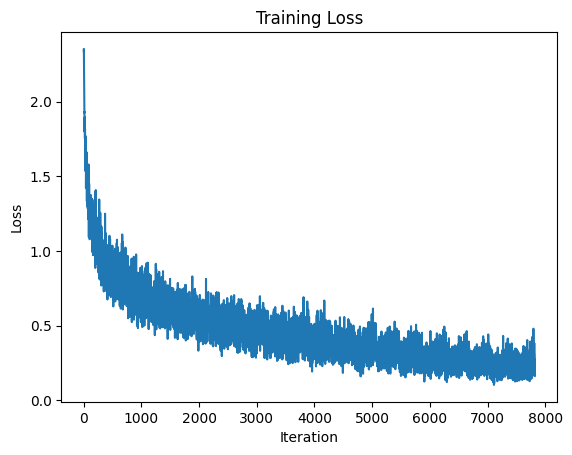

In [10]:
# Plotting the training loss
plt.figure()
plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Test and save the model's weights

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total:.2f} %')

Accuracy of the network on the test images: 79.00 %


In [15]:
# Save the trained model weights
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print('Saved the model weights')

Saved the model weights


## Train the ABNN version

### BNL old versions

In [ ]:
class BNL(nn.Module):
    """
    Bayesian Normalization Layer (BNL).

    This layer replaces traditional normalization including like BatchNorm,
    LayerNorm, and InstanceNorm. It adapts normalization to account for Bayesian
    inference, making the model more robust to variations and uncertainties in
    the data.

    BNL adds gaussian noise during both inference and trainig stages.

    Args:
        num_features (int): The number of features in the input.

    Methods:
        forward(x): Applies Bayesian normalization to the input tensor.
    """
    def __init__(self, num_features):
        super(BNL, self).__init__()
        self.num_features = num_features
        self.gamma_4d = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta_4d = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.gamma_2d = nn.Parameter(torch.ones(1, num_features))
        self.beta_2d = nn.Parameter(torch.zeros(1, num_features))
        self.eps = 1e-5

    def forward(self, x):
        if x.dim() == 4:  # 4D Input: Used for mini-batch of images. The four dimensions are [batch size, channels, height, width]
            batch_mean = torch.mean(x, dim=(0, 2, 3), keepdim=True)
            batch_var = torch.var(x, dim=(0, 2, 3), keepdim=True)
            noise = torch.randn(x.shape[0], self.num_features, 1, 1).to(x.device)
            x = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
            x = x * (self.gamma_4d * (1 + noise)) + self.beta_4d
        elif x.dim() == 2:  # 2D Input: common for in fully connected layers. The two dimensions are [batch size, features]
            batch_mean = torch.mean(x, dim=0, keepdim=True)
            batch_var = torch.var(x, dim=0, keepdim=True)
            noise = torch.randn(x.shape[0], self.num_features).to(x.device)
            x = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
            x = x * (self.gamma_2d * (1 + noise)) + self.beta_2d
        else:
            raise ValueError(f"Unsupported input dimensions: {x.dim()}")
        return x

In [ ]:
class BNL(nn.Module):
    def __init__(self, num_features, epsilon_std=1.0):
        super(BNL, self).__init__()
        self.num_features = num_features
        self.epsilon_std = epsilon_std

        # Learnable parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        # Running statistics
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

        # Initialize the random noise
        self.epsilon = torch.randn(num_features) * self.epsilon_std

    def forward(self, x):
        device = x.device  # Get the device of the input tensor

        # Ensure running statistics are on the same device
        self.running_mean = self.running_mean.to(device)
        self.running_var = self.running_var.to(device)
        self.gamma = self.gamma.to(device)
        self.beta = self.beta.to(device)
        self.epsilon = self.epsilon.to(device)

        if self.training:
            batch_mean = torch.mean(x, dim=[0, 2, 3])
            batch_var = torch.var(x, dim=[0, 2, 3], unbiased=False)

            # Update running statistics
            self.running_mean = 0.9 * self.running_mean + 0.1 * batch_mean
            self.running_var = 0.9 * self.running_var + 0.1 * batch_var
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var

        # Add Gaussian noise to gamma
        if self.training:
            self.epsilon = torch.randn(self.num_features, device=device) * self.epsilon_std
        gamma_noisy = self.gamma * (1 + self.epsilon)

        # Normalize the input
        x_normalized = (x - batch_mean[None, :, None, None]) / torch.sqrt(batch_var[None, :, None, None] + 1e-5)

        return gamma_noisy[None, :, None, None] * x_normalized + self.beta[None, :, None, None]

In [ ]:
class BNL(nn.Module):
    def __init__(self, num_features, epsilon_std=1.0):
        super(BNL, self).__init__()
        self.num_features = num_features
        self.epsilon_std = epsilon_std

        # Learnable parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        # Running statistics
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def forward(self, x):
        device = x.device
        self.running_mean = self.running_mean.to(device)
        self.running_var = self.running_var.to(device)
        self.gamma = self.gamma.to(device)
        self.beta = self.beta.to(device)

        if x.dim() == 4:  # Input from conv layers
            if self.training:
                batch_mean = x.mean([0, 2, 3], keepdim=True)
                batch_var = x.var([0, 2, 3], keepdim=True, unbiased=False)
                self.running_mean = 0.9 * self.running_mean + 0.1 * batch_mean.squeeze()
                self.running_var = 0.9 * self.running_var + 0.1 * batch_var.squeeze()
            else:
                batch_mean = self.running_mean.view(1, -1, 1, 1)
                batch_var = self.running_var.view(1, -1, 1, 1)
        elif x.dim() == 2:  # Input from fully connected layers
            if self.training:
                batch_mean = x.mean(0, keepdim=True)
                batch_var = x.var(0, keepdim=True, unbiased=False)
                self.running_mean = 0.9 * self.running_mean + 0.1 * batch_mean.squeeze()
                self.running_var = 0.9 * self.running_var + 0.1 * batch_var.squeeze()
            else:
                batch_mean = self.running_mean.view(1, -1)
                batch_var = self.running_var.view(1, -1)

        if self.training:
            self.epsilon = torch.randn(self.num_features, device=device) * self.epsilon_std
        else:
            self.epsilon = torch.zeros(self.num_features, device=device)

        gamma_noisy = self.gamma * (1 + self.epsilon)

        # Normalize the input
        x_normalized = (x - batch_mean) / torch.sqrt(batch_var + 1e-5)

        # Adjust gamma and beta for broadcasting
        if x.dim() == 4:
            gamma_noisy = gamma_noisy.view(1, -1, 1, 1)
            beta = self.beta.view(1, -1, 1, 1)
        elif x.dim() == 2:
            gamma_noisy = gamma_noisy.view(1, -1)
            beta = self.beta.view(1, -1)

        return gamma_noisy * x_normalized + beta


### BNL and ABNN loss current version

In [13]:
# class BNL(nn.Module):
#     """
#     Bayesian Normalization Layer (BNL) that can directly replace traditional
#     normalization layers like BatchNorm, enabling easier weight transfer from models
#     using BatchNorm.

#     This implementation includes parameters named `weight` and `bias` to directly
#     match those used in PyTorch's BatchNorm layers for compatibility when loading
#     state dictionaries.

#     Args:
#         num_features (int): Number of features in the input, matches channels in conv
#                             layers or features in linear layers.
#     """
#     def __init__(self, num_features):
#         super(BNL, self).__init__()
#         self.num_features = num_features
#         self.weight = nn.Parameter(torch.ones(num_features))
#         self.bias = nn.Parameter(torch.zeros(num_features))
#         self.eps = 1e-5

#     def forward(self, x):
#         mean = x.mean([0, 2, 3], keepdim=True) if x.dim() == 4 else x.mean(0, keepdim=True)
#         var = x.var([0, 2, 3], keepdim=True) if x.dim() == 4 else x.var(0, keepdim=True)
#         x_normalized = (x - mean) / torch.sqrt(var + self.eps)

#         # Gaussian noise applied to the weights
#         noise = torch.randn(self.weight.shape, device=x.device)
#         gamma_noisy = self.weight * (1 + noise)

#         if x.dim() == 4:
#             gamma_noisy = gamma_noisy.view(1, -1, 1, 1)
#             bias = self.bias.view(1, -1, 1, 1)
#         elif x.dim() == 2:
#             gamma_noisy = gamma_noisy.view(1, -1)
#             bias = self.bias.view(1, -1)

#         return gamma_noisy * x_normalized + bias


# class BNL_layer(nn.Module):  # for special case of layer normalization tha takes a list input
#     def __init__(self, num_features):
#         super(BNL_layer, self).__init__()
#         if isinstance(num_features, int):
#             num_features = (num_features,)
#         elif isinstance(num_features, list):
#             num_features = tuple(num_features)

#         self.num_features = num_features
#         self.weight = nn.Parameter(torch.ones(num_features))
#         self.bias = nn.Parameter(torch.zeros(num_features))
#         self.eps = 1e-5

#     def forward(self, x):
#         mean = x.mean(dim=tuple(range(x.dim())[1:]), keepdim=True)
#         var = x.var(dim=tuple(range(x.dim())[1:]), keepdim=True, unbiased=False)
#         x_normalized = (x - mean) / torch.sqrt(var + self.eps)

#         noise = torch.randn(self.weight.shape, device=x.device)
#         gamma_noisy = self.weight * (1 + noise)

#         weight = self.weight.view((1,) + self.num_features + (1,) * (x.dim() - len(self.num_features) - 1))
#         bias = self.bias.view((1,) + self.num_features + (1,) * (x.dim() - len(self.num_features) - 1))

#         return gamma_noisy * x_normalized + bias

In [16]:
import torch
import torch.nn as nn

class BNL(nn.Module):
    """
        Bayesian Normalization Layer (BNL).

    This layer replaces traditional normalization layers like BatchNorm,
    LayerNorm, and InstanceNorm. It adapts normalization to account for Bayesian
    inference, making the model more robust to variations and uncertainties in
    the data.

    BNL adds gaussian noise during both inference and trainig stages.

    This implementation includes parameters named `weight` and `bias` to directly
    match those used in PyTorch's BatchNorm, LayerNorm, and InstanceNorm layers
    for compatibility when loading state dictionaries.

    Args:
        num_features (int, list, tuple): Number of features in the input, matches channels
                                         in conv layers or features in linear layers. Can
                                         be a single integer or a list/tuple for complex scenarios.
    """
    def __init__(self, num_features):
        super(BNL, self).__init__()
        # Check if num_features is a list or tuple, convert if necessary
        if isinstance(num_features, int):
            num_features = (num_features,)

        self.num_features = num_features
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))
        self.eps = 1e-5

    def forward(self, x):
        if len(self.num_features) == 1:  # Traditional usage like BatchNorm
            mean = x.mean([0, 2, 3], keepdim=True) if x.dim() == 4 else x.mean(0, keepdim=True)
            var = x.var([0, 2, 3], keepdim=True) if x.dim() == 4 else x.var(0, keepdim=True)
            x_normalized = (x - mean) / torch.sqrt(var + self.eps)

            noise = torch.randn(self.weight.shape, device=x.device)
            gamma_noisy = self.weight * (1 + noise)

            if x.dim() == 4:
                gamma_noisy = gamma_noisy.view(1, -1, 1, 1)
                bias = self.bias.view(1, -1, 1, 1)
            elif x.dim() == 2:
                gamma_noisy = gamma_noisy.view(1, -1)
                bias = self.bias.view(1, -1)

            return gamma_noisy * x_normalized + bias
        else:  # LayerNorm-like usage
            mean = x.mean(dim=tuple(range(x.dim())[1:]), keepdim=True)
            var = x.var(dim=tuple(range(x.dim())[1:]), keepdim=True, unbiased=False)
            x_normalized = (x - mean) / torch.sqrt(var + self.eps)

            noise = torch.randn(self.weight.shape, device=x.device)
            gamma_noisy = self.weight * (1 + noise)

            weight = self.weight.view((1,) + self.num_features + (1,) * (x.dim() - len(self.num_features) - 1))
            bias = self.bias.view((1,) + self.num_features + (1,) * (x.dim() - len(self.num_features) - 1))

            return gamma_noisy * x_normalized + bias

In [17]:
class ABNNLoss(torch.nn.Module):
    def __init__(self, Num_classes, model_parameters, Weight_decay=1e-4):
        super(ABNNLoss, self).__init__()
        self.model_parameters = model_parameters
        self.Weight_decay = Weight_decay
        self.eta = nn.Parameter(torch.ones(Num_classes))

    def forward(self, outputs, labels):
        # Calculate the three loss components
        nll_loss = self.negative_log_likelihood(outputs, labels)
        log_prior_loss = self.negative_log_prior(self.model_parameters, self.Weight_decay)
        custom_ce_loss = self.custom_cross_entropy_loss(outputs, labels, self.eta)

        # Sum up all three components to form the ABNN loss
        total_loss = nll_loss + log_prior_loss + custom_ce_loss
        return total_loss

    @staticmethod
    def negative_log_likelihood(outputs, labels):
        # Negative Log Likelihood (NLL) or MLE Loss:
        # NLL = -∑ log P(y_i | x_i, ω)
        return torch.nn.functional.cross_entropy(outputs, labels)

    def negative_log_prior(self, model_parameters, Weight_decay=1e-4):
        # Negative Log Prior with Gaussian Prior (L2 Regularization):
        # log P(ω) = λ ∑ ω^2 where λ (weight decay) = (1/2σ^2)
        l2_reg = sum(p.pow(2).sum() for p in model_parameters)
        return Weight_decay * l2_reg

    def custom_cross_entropy_loss(self, outputs, labels, eta):
        # Custom Cross-Entropy Loss:
        # E(ω) = -∑ η_i log P(y_i | x_i, ω)
        log_probs = torch.nn.functional.log_softmax(outputs, dim=1)
        weighted_log_probs = eta[labels] * log_probs.gather(1, labels.unsqueeze(1)).squeeze(1)
        return -torch.mean(weighted_log_probs)

### Define the CNN's ABNN version

In [18]:
class ABNNNet(nn.Module):
    def __init__(self):
        super(ABNNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = BNL(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.in2 = BNL(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.ln3 = BNL((128, 8, 8))
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.ln4 = BNL(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn5 = BNL(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.in2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 4 * 4)

        x = self.fc1(x)
        x = self.ln4(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [19]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

abnnnet = ABNNNet()
abnnnet.to(device)

# Print the summary of the model
summary(abnnnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
               BNL-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
               BNL-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
               BNL-8            [-1, 128, 8, 8]          16,384
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 256]         524,544
              BNL-11                  [-1, 256]             512
           Linear-12                  [-1, 128]          32,896
              BNL-13                  [-1, 128]             256
           Linear-14                   

### Training the new model

In [20]:
loss_func = ABNNLoss(10, abnnnet.parameters()).to(device)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, abnnnet.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)

In [24]:
state_dict = torch.load('./cifar_net.pth')

# Filter out the keys related to running statistics that BNL doesn't use
filtered_state_dict = {k: v for k, v in state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}

# Load the filtered state dictionary
abnnnet.load_state_dict(filtered_state_dict, strict=True)
print('Model weights loaded.')

Model weights loaded.


In [25]:
print("Keys in the state dictionary:")
for key in state_dict.keys():
    print(key)

Keys in the state dictionary:
conv1.weight
conv1.bias
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
conv2.weight
conv2.bias
in2.weight
in2.bias
conv3.weight
conv3.bias
ln3.weight
ln3.bias
fc1.weight
fc1.bias
ln4.weight
ln4.bias
fc2.weight
fc2.bias
bn5.weight
bn5.bias
bn5.running_mean
bn5.running_var
bn5.num_batches_tracked
fc3.weight
fc3.bias


In [26]:
print('Start Training')

# Timing the training process
start_time = time.time()

# List to store loss values
train_losses = []
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        eta = torch.rand(labels.size(0), device=device)

        optimizer.zero_grad()
        outputs = abnnnet(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(loss.item())
    print(f'[Epoch {epoch + 1}, Loss: {running_loss}')
    running_loss = 0.0

end_time = time.time()

print('Finished Training')
print(f'Time taken to train the model: {end_time - start_time:.2f} seconds')

Start Training
[Epoch 1, Loss: 1256.3802634477615
[Epoch 2, Loss: 931.4795205593109
[Epoch 3, Loss: 853.3990067243576
[Epoch 4, Loss: 817.771817445755
[Epoch 5, Loss: 793.523169875145
[Epoch 6, Loss: 770.1933164596558
[Epoch 7, Loss: 755.0068476200104
[Epoch 8, Loss: 735.917240023613
[Epoch 9, Loss: 725.2883818149567
[Epoch 10, Loss: 713.6974112987518
[Epoch 11, Loss: 702.5278379917145
[Epoch 12, Loss: 693.9569231271744
[Epoch 13, Loss: 679.0479393005371
[Epoch 14, Loss: 680.1117898225784
[Epoch 15, Loss: 665.6557961702347
[Epoch 16, Loss: 670.6050525903702
[Epoch 17, Loss: 658.3752547502518
[Epoch 18, Loss: 657.5034958124161
[Epoch 19, Loss: 648.2052940130234
[Epoch 20, Loss: 642.9247715473175
Finished Training
Time taken to train the model: 547.83 seconds


In [27]:
# Make sure the model is in evaluation mode
abnnnet.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = abnnnet(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 78.48%


In [28]:
# # Instantiate the custom ABNN loss class
# eta = torch.rand(64, device=device)  # Adjust the size of `eta` to match your batch size
# criterion = ABNNLoss(weight_decay=5e-4).to(device)
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, abnnnet.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)

In [29]:
# Save the trained model weights
PATH = './cifar_abnnnet.pth'
torch.save(abnnnet.state_dict(), PATH)
print('Saved the model weights')

Saved the model weights


## Download the generated outputs (for colab)

In [ ]:
# from google.colab import files
# files.download('/content/cifar_net.pth')
# files.download('/content/ABNNNet.py')
# files.download('/content/cifar_abnnnet.pth')